In [189]:
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings

def z_wall(z=4, f=128, h=256, w=384, cx=192, cy=128):
  x, y = np.meshgrid(np.arange(w), np.arange(h))
  x = x - cx
  y = y - cy

  Z = depth = x - x + z
  N = np.zeros((h, w, 3), dtype=np.float64)
  N[:,:,2] = -1.
  A = np.mod(x // 64 + y // 64, 2) * 0.5 + 0.1
  A[:] = 0.4
  S = A - A
  return Z, N, A, S

def sphere(r=1.2, z=2, specular=False, f=128, h=256, w=384, cx=192, cy=128):
  # Let's assume that camera is at origin looking in the +Z direction. X axis
  # to the right, Y axis downwards.
  # Let's assume that the sphere is at (0, 0, z) and of radius r.
  x, y = np.meshgrid(np.arange(w), np.arange(h))
  x = x - cx
  y = y - cy
    
# X = xZ/f

  phi = np.arccos(f / np.sqrt(x**2 + y**2 + f**2))
  # equation is rho*2 (1+tan^2(phi)) - 2 rho * z + z*z - r*r = 0
  a = np.tan(phi)**2 + 1
  b = -2 * z
  c = z**2 - r**2
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rho = -b - np.sqrt(b**2 - 4*a*c) 
  rho = rho / 2 / a
  depth = rho
  
  # Calculate the point on the sphere surface
  X = x * depth / f
  Y = y * depth / f
  Z = depth
  N = np.array([X, Y, Z])
  N = np.transpose(N, [1,2,0])
  N = N - np.array([[[0, 0, z]]])
  N = N / np.linalg.norm(N, axis=2, keepdims=True)
  Z[np.isnan(Z)] = np.inf

  # Compute k_d, k_a 
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    A = (np.sign(X*Y) > 0) * 0.5 + 0.1
  
  # Set specularity
  if specular:
    S = np.invert(np.isinf(depth)) + 0
  else:
    S = A-A
  return Z, N, A, S

def compose(Z1, N1, A1, S1, Z2, N2, A2, S2):
  ind = np.argmin(np.array([Z1, Z2]), axis=0)
  Z = Z1 + 0
  Z[ind == 1] = Z2[ind == 1]
  A = A1 + 0
  A[ind == 1] = A2[ind == 1]
  S = S1 + 0
  S[ind == 1] = S2[ind == 1]
  N = N1 + 0
  ind = np.repeat(ind[:, :, np.newaxis], 3, axis=2)
  N[ind == 1] = N2[ind == 1]
  return Z, N, A, S

def get_ball(specular):
  Z1, N1, A1, S1 = sphere(specular=specular)
  Z2, N2, A2, S2 = z_wall()
  Z, N, A, S = compose(Z1, N1, A1, S1, Z2, N2, A2, S2)
  return Z, N, A, S
  

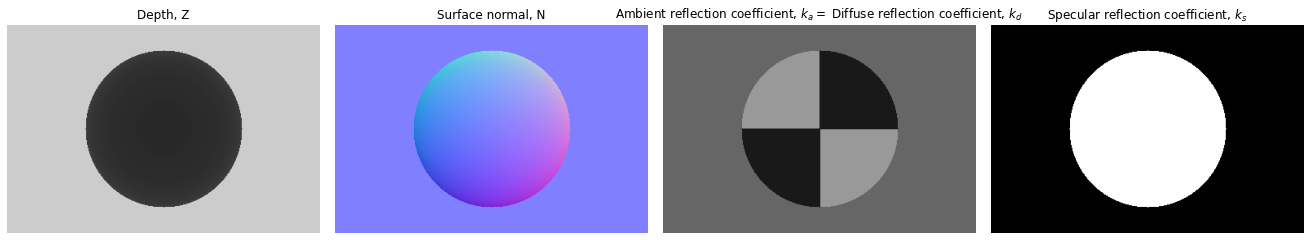

In [190]:
Z1, N1, A1, S1 = sphere(specular=True)
Z2, N2, A2, S2 = z_wall()
Z, N, A, S = compose(Z1, N1, A1, S1, Z2, N2, A2, S2)

fig = plt.figure(constrained_layout=False, figsize=(20, 5))
gs1 = fig.add_gridspec(nrows=1, ncols=4, left=0.05, right=0.95, wspace=0.05, top=0.95, bottom=0.05)
axes = []
for i in range(4):
    axes.append(fig.add_subplot(gs1[0,i]))
    axes[-1].set_axis_off()

axes[0].imshow(Z, cmap='gray', vmin=0, vmax=5)
axes[0].set_title('Depth, Z')
# visualizing surface normals using a commonly used color map.
N[:,:,0] = -N[:,:,0]
axes[1].imshow((-N[:,:,[0,1,2]]+1)/2.)
axes[1].set_title('Surface normal, N')
axes[2].imshow(A, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Ambient reflection coefficient, $k_a =$ Diffuse reflection coefficient, $k_d$')
axes[3].imshow(S, cmap='gray', vmin=0, vmax=1)
axes[3].set_title('Specular reflection coefficient, $k_s$')
plt.savefig('input.png', bbox_inches='tight')

In [215]:
# specular exponent
k_e = 50

def render(Z, N, A, S, 
            point_light_loc, point_light_strength, 
            directional_light_dirn, directional_light_strength,
            ambient_light, k_e):
    # To render the images you will need the camera parameters, you can assume
    # the following parameters. 
    #(cx, cy) denote the center of the image (point
    # where the optical axis intersects with the image, f is the focal length.
    # These parameters along with the depth image will be useful for you to
    # estimate the 3D points on the surface of the sphere for computing the
    # angles between the different directions.
    # N.shape #(256, 384, 3)
    # Z.shape #(256, 384)
    # vi: directional_light_dirn.shape: (1, 3)
    # point_light_loc = [[0, -10, 2]]
    h, w = A.shape
    cx, cy = w / 2, h /2
    f = 128.
#     print(Z.shape)
    # Ambient Term
    I = A * ambient_light
    
    #Diffuse Term
    #point_light_strength * [dot product of v_i (for point light) and n] + directional_light_strength * [dot product of v_i (for directional light) and n]
    
    #take care vi and n as shape (256, 384, 3)
    N = np.array(N)
    n1, n2, n3 = N.shape
    directional_light_dirn = np.array(directional_light_dirn)
    directional_light_dirn = directional_light_dirn - np.zeros(N.shape)
    for i in range(n1):
        for j in range(n2):
            directional_light_dirn[i][j] = directional_light_dirn[i][j]/ np.linalg.norm(directional_light_dirn[i][j])
    
#     directional_light_dirn = directional_light_dirn/ np.linalg.norm(directional_light_dirn)
    #D for directional_light
    Li_vi_dot_n_directional = directional_light_strength[0] * helper(directional_light_dirn, N)
    D_directional_light = np.multiply(A, Li_vi_dot_n_directional)
    
    #calculate vi for point light
    point_light_loc = np.array(point_light_loc)
    point_light_dirn = np.zeros((n1,n2,n3))
    
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    x = x - cx
    y = y - cy
    X = x / f * Z
    Y = y / f * Z
    
    for i in range(n1):
        for j in range(n2):
            point_light_dirn[i][j] = point_light_loc - np.array([X[i][j],Y[i][j],Z[i][j]])
            point_light_dirn[i][j] = point_light_dirn[i][j]/ np.linalg.norm(point_light_dirn[i][j])
    

    Li_vi_dot_n_point = point_light_strength[0] * helper(point_light_dirn, N)
    D_point_light = np.multiply(A, Li_vi_dot_n_point)

    D = D_directional_light + D_point_light
    
    
    # Specular Term
    vr = np.zeros((n1,n2,n3))
    for i in range(n1):
        for j in range(n2):
            vr[i][j] = -np.array([X[i][j],Y[i][j],Z[i][j]])
            vr[i][j] = vr[i][j]/ np.linalg.norm(vr[i][j])
    
    #calculate si
    directional_light_si = np.zeros(directional_light_dirn.shape)
    for i in range(n1):
        for j in range(n2):
            directional_light_si[i][j] = -directional_light_dirn[i][j] - 2 *(np.dot(-directional_light_dirn[i][j], N[i][j]))* N[i][j]
    
    point_light_si = np.zeros(point_light_dirn.shape)
    for i in range(n1):
        for j in range(n2):
            point_light_si[i][j] = -point_light_dirn[i][j] - 2 *(np.dot(-point_light_dirn[i][j], N[i][j]))* N[i][j]
    
    vr_si_directional = helper(vr,directional_light_si)
    vr_si_point = helper(vr,point_light_si)
    
    S_directional = S * directional_light_strength[0] *  vr_si_directional**k_e
    S_point = S * point_light_strength[0] * vr_si_point**k_e
    
    S = S_directional + S_point
    

    I = I + D + S

    I = np.minimum(I, 1)*255
    I = I.astype(np.uint8)
    I = np.repeat(I[:,:,np.newaxis], 3, axis=2)

    return I

def helper(directional_light_dirn, N):
    n1, n2, n3 = N.shape
    ans = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            tmp = directional_light_dirn[i][j][0]* N[i][j][0] + directional_light_dirn[i][j][1]* N[i][j][1] + directional_light_dirn[i][j][2]* N[i][j][2]
            if tmp > 0:
                ans[i][j] = tmp
    return ans 

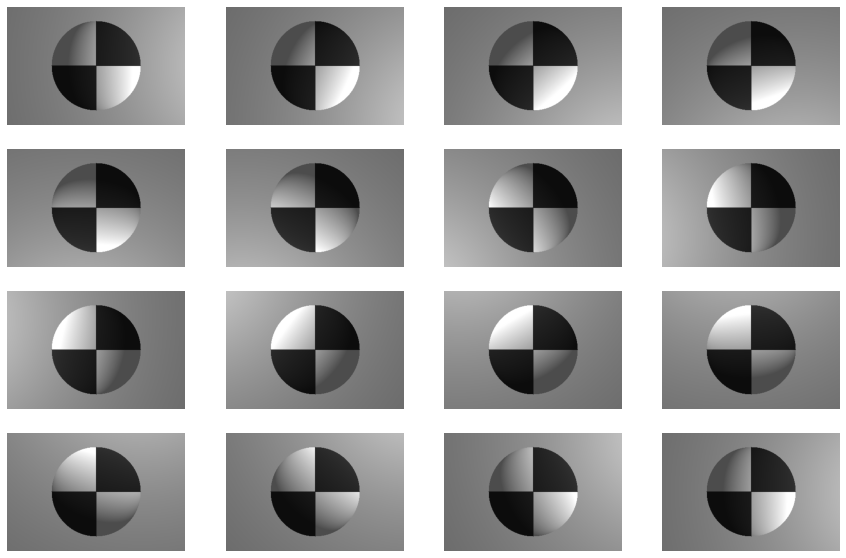

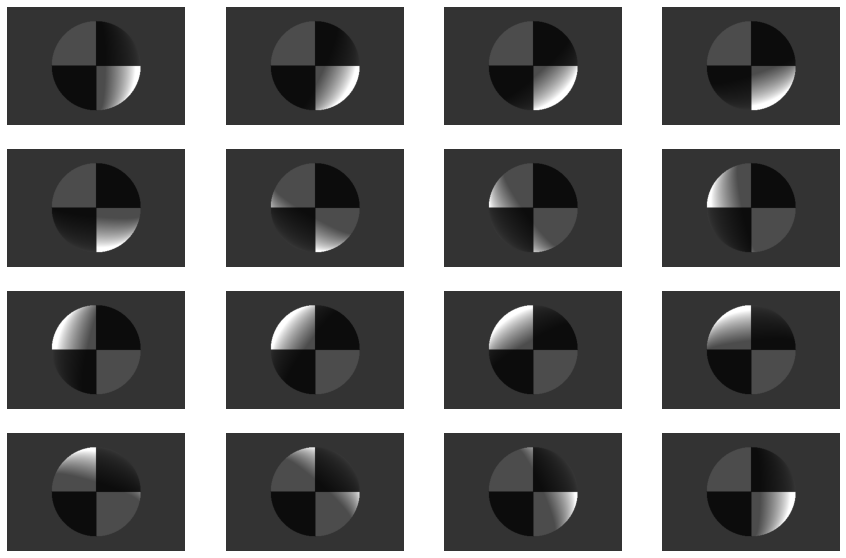

In [216]:
for specular in [False]:
    # get_ball function returns:
    # - Z (depth image: distance to scene point from camera center, along the
    # Z-axis)
    # - N is the per pixel surface normals (N[:,:,0] component along X-axis
    # (pointing right), N[:,:,1] component along Y-axis (pointing down),
    # N[:,:,2] component along Z-axis (pointing into the scene)),
    # - A is the per pixel ambient and diffuse reflection coefficient per pixel,
    # - S is the per pixel specular reflection coefficient.
    Z, N, A, S = get_ball(specular=specular)

    # Strength of the ambient light.
    ambient_light = 0.5
    
    # For the following code, you can assume that the point sources are located
    # at point_light_loc and have a strength of point_light_strength. For the
    # directional light sources, you can assume that the light is coming _from_
    # the direction indicated by directional_light_dirn, and with strength
    # directional_light_strength. The coordinate frame is centered at the
    # camera, X axis points to the right, Y-axis point down, and Z-axis points
    # into the scene.
    
    # Case I: No directional light, only point light source that moves around
    # the object. 
    point_light_strength = [1.5]
    directional_light_dirn = [[1, 0, 0]]
    directional_light_strength = [0.0]
    
    fig, axes = plt.subplots(4, 4, figsize=(15,10))
    axes = axes.ravel()[::-1].tolist()
    for theta in np.linspace(0, np.pi*2, 16): 
      point_light_loc = [[10*np.cos(theta), 10*np.sin(theta), -3]]
      I = render(Z, N, A, S, point_light_loc, point_light_strength, 
                 directional_light_dirn, directional_light_strength,
                 ambient_light, k_e)
      ax = axes.pop()
      ax.imshow(I)
      ax.set_axis_off()
    plt.show()
    plt.savefig(f'specular{specular:d}_move_point.png', bbox_inches='tight')
    plt.close()

    # Case II: No point source, just a directional light source that moves
    # around the object.
    point_light_loc = [[0, -10, 2]]
    point_light_strength = [0.0]
    directional_light_strength = [2.5]
    
    fig, axes = plt.subplots(4, 4, figsize=(15,10))
    axes = axes.ravel()[::-1].tolist()
    for theta in np.linspace(0, np.pi*2, 16): 
      directional_light_dirn = [np.array([np.cos(theta), np.sin(theta), .1])]
      directional_light_dirn[0] = \
        directional_light_dirn[0] / np.linalg.norm(directional_light_dirn[0])
      I = render(Z, N, A, S, point_light_loc, point_light_strength, 
                 directional_light_dirn, directional_light_strength,
                 ambient_light, k_e) 
      ax = axes.pop()
      ax.imshow(I)
      ax.set_axis_off()
    plt.show()
    plt.savefig(f'specular{specular:d}_move_direction.png', bbox_inches='tight')
    plt.close()